In [1]:
!pip install -q tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import copy
import io
from tqdm import tqdm
from google.colab import files
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

imsize = 512 if torch.cuda.is_available() else 256

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std  = torch.tensor([0.229, 0.224, 0.225]).to(device)

def image_to_tensor(img_pil):
    img = loader(img_pil).unsqueeze(0)
    return img.to(device, torch.float)

def tensor_to_image(tensor):
    tensor = tensor.clone().detach().cpu().squeeze(0)
    return transforms.ToPILImage()(tensor.clamp(0, 1))

def show_pil(img_pil, title=None):
    plt.figure(figsize=(6,6))
    plt.axis('off')
    if title: plt.title(title)
    plt.imshow(img_pil)
    plt.show()


Using device: cpu


Upload content image (photo) then style image (painting).


Saving This is an 11 x 14 acrylic on canvas Mediterranean Greek Islands village alley to the sea _ #greece #greeceislands #acryliconcanvas #mediterranean #mediterraneanart #mediterraneanpainting #artoftheday🎨 #artofthe.jpeg to This is an 11 x 14 acrylic on canvas Mediterranean Greek Islands village alley to the sea _ #greece #greeceislands #acryliconcanvas #mediterranean #mediterraneanart #mediterraneanpainting #artoftheday🎨 #artofthe.jpeg
Saving 10 Mind-Blowing Paint Pouring Art Projects You Can Do This Weekend (You’ll Be Shocked by #3!).jpeg to 10 Mind-Blowing Paint Pouring Art Projects You Can Do This Weekend (You’ll Be Shocked by #3!) (1).jpeg
Content: This is an 11 x 14 acrylic on canvas Mediterranean Greek Islands village alley to the sea _ #greece #greeceislands #acryliconcanvas #mediterranean #mediterraneanart #mediterraneanpainting #artoftheday🎨 #artofthe.jpeg
Style  : 10 Mind-Blowing Paint Pouring Art Projects You Can Do This Weekend (You’ll Be Shocked by #3!) (1).jpeg


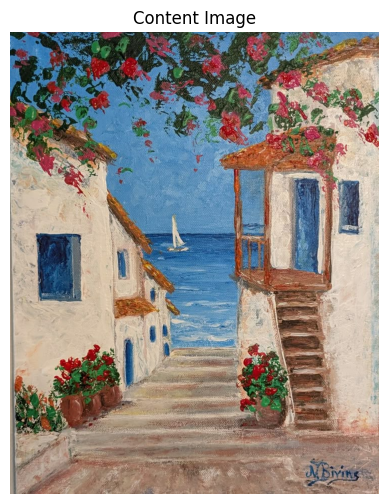

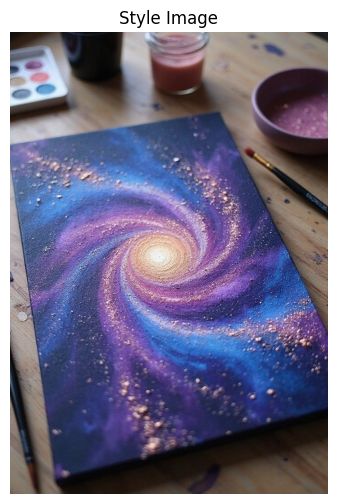

In [4]:
print("Upload content image (photo) then style image (painting).")
uploaded = files.upload()
fnames = list(uploaded.keys())
if len(fnames) < 2:
    raise RuntimeError("Please upload at least two image files (content, then style).")
content_path = fnames[0]
style_path   = fnames[1]
print("Content:", content_path)
print("Style  :", style_path)

content_img = Image.open(content_path).convert('RGB')
style_img   = Image.open(style_path).convert('RGB')

show_pil(content_img, title="Content Image")
show_pil(style_img, title="Style Image")


In [5]:
content_layers_default = ['conv_4']
style_layers_default   = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        features = input.view(b * c, h * w)
        G = torch.mm(features, features.t())
        return G.div(b * c * h * w)

class ContentLoss(nn.Module):
    def __init__(self, target,):
        super().__init__()
        self.target = target.detach()
        self.loss = 0.0
    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = GramMatrix()(target_feature).detach()
        self.loss = 0.0
    def forward(self, input):
        G = GramMatrix()(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        # reshape to [C x 1 x 1]
        self.mean = mean.clone().detach().view(-1,1,1)
        self.std  = std.clone().detach().view(-1,1,1)
    def forward(self, img):
        return (img - self.mean) / self.std

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn).features.to(device).eval()

    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)

    content_losses = []
    style_losses = []

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            name = f'layer_{i}'

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for j in range(len(model) -1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break
    model = model[:j+1]

    return model, style_losses, content_losses


In [6]:
content_tensor = image_to_tensor(content_img)
style_tensor   = image_to_tensor(style_img)

input_tensor = content_tensor.clone()

cnn = models.vgg19(pretrained=True).to(device).eval()

model, style_losses, content_losses = get_style_model_and_losses(
    cnn, cnn_normalization_mean, cnn_normalization_std,
    style_tensor, content_tensor
)

style_weight = 1e6
content_weight = 1

input_tensor.requires_grad_(True)
optimizer = optim.LBFGS([input_tensor])

print("Starting optimization... (this can take a few minutes)")

num_steps = 300

run = [0]
pbar = tqdm(total=num_steps)
while run[0] <= num_steps:

    def closure():
        input_tensor.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_tensor)
        style_score = 0.0
        content_score = 0.0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        pbar.update(1)
        return loss

    optimizer.step(closure)
    if run[0] > num_steps:
        break

pbar.close()
input_tensor.data.clamp_(0, 1)
print("Optimization done.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 78.3MB/s]


Starting optimization... (this can take a few minutes)


320it [04:26,  1.20it/s]

Optimization done.


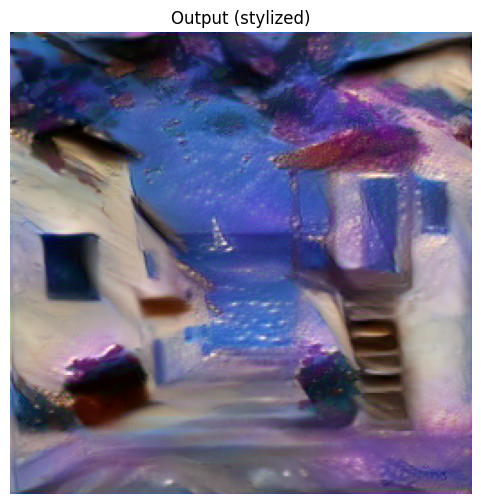

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved: stylized_result.png


In [7]:
output_image = tensor_to_image(input_tensor)
show_pil(output_image, title="Output (stylized)")

out_name = "stylized_result.png"
output_image.save(out_name)
from google.colab import files
files.download(out_name)
print("Saved:", out_name)